In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
sns.set_style("whitegrid")

from constants import LOCATION_CHOOSEN, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

df['date'] = pd.to_datetime(df['date'])
# creating new columns
df['N'] = df['population']
df['S'] = df['population'] - (df['total_cases'] + df['people_fully_vaccinated'])
df['I'] = df['total_cases']
df['R'] = df['people_fully_vaccinated']

In [3]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'N', 'S', 'I', 'R', 'S_modelled', 'I_modelled',
       'R_modelled', 'r_eff_actual', 'gdp_min_max_normalized', 'reward',
       'S_modelled_fakemoves', 'I_modelled_fakemoves', 'R_modelled_fakemoves',
       'r_eff_actual_fakemoves', 'gdp_fakemoves_min_max_normalized',
       'reward_fakemoves'],
      dtype='object')


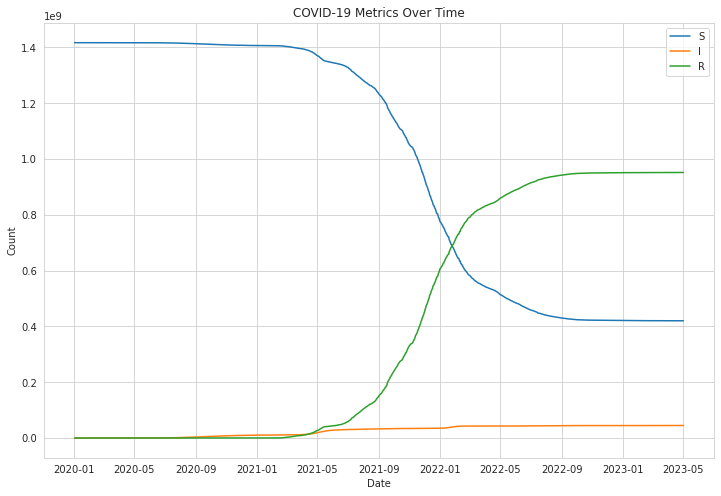

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [5]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    n = len(data)
    return (100 / n) * np.sum(np.abs((data - predictions) / data))

def compute_cost(data, predictions):
    return np.sum(np.square(data - predictions))

def compute_cost(data, predictions):
    return np.abs(data - predictions).mean()

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [6]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

In [7]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(optimal_beta, optimal_gamma)
print(optimal_beta/optimal_gamma)

0.07311369954074455 0.044111538344129904
1.6574733569788114


In [8]:
ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

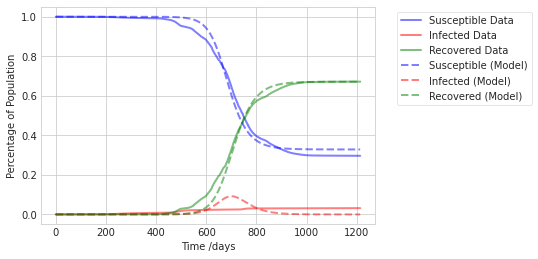

In [9]:
plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [10]:
cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(cost)

74733884.22167633


In [11]:
def deriv_2(y, t, N, beta_array, gamma):
    S, I, R = y
    t = min(int(t), len(beta_array) - 1)
    dSdt = -beta_array[t] * S * I / N
    dIdt = beta_array[t] * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
    
def time_varying_beta(optimal_beta, stringency_weight, stringency_index):
    beta = optimal_beta + (stringency_weight * stringency_index)
    return beta

def objective_function_2(params, y0, t, N, df, gamma, all_stringencies):
    stringency_weight = params[0]
    
    beta_array = time_varying_beta(optimal_beta, stringency_weight, all_stringencies)
    
    predictions = odeint(deriv_2, y0, t, args=(N, beta_array, gamma))
    S, I, R = predictions.T
    
    cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
    return cost

In [12]:
# Set initial values
initial_guess_for_stringency_weight = [0.01]
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)
current_stringency = df['stringency_index'].values

# Perform the optimization
result = minimize(
    objective_function_2,
    initial_guess_for_stringency_weight,
    args=(y0, t, N, df, optimal_gamma, current_stringency),
    method='Nelder-Mead',
)

optimal_stringency_weight = result.x[0]
print(f"Optimal stringency weight: {optimal_stringency_weight}")

Optimal stringency weight: -4.307369509681814e-11


In [13]:
store_S = []
store_I = []
store_R = []

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

for ith_day in range(0, days_difference + 1):
    t = np.linspace(0, ith_day, ith_day+1)
    
    stringency_index = df['stringency_index'].iloc[ith_day]
    beta_for_stringency = time_varying_beta(optimal_beta, optimal_stringency_weight, stringency_index)
    predictions = odeint(deriv, y0, t, args=(N, beta_for_stringency, optimal_gamma))
    S, I, R = predictions.T
    store_S.append(S[-1])
    store_I.append(I[-1])
    store_R.append(R[-1])

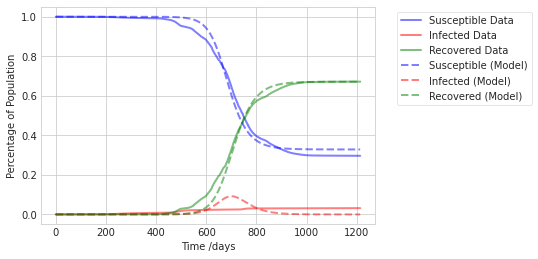

In [14]:
plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, store_S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, store_I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, store_R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_beta_varying_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [15]:
stringency_optimized_cost = compute_cost(df['S'], store_S) + compute_cost(df['I'], store_I) + compute_cost(df['R'], store_R)
print(stringency_optimized_cost)

74733884.09450117


In [16]:
print(cost - stringency_optimized_cost)

0.12717516720294952


In [17]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma,
    'optimal_stringency_weight': optimal_stringency_weight
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [18]:
print(min(t), max(t))

0.0 1214.0


In [19]:
betas = time_varying_beta(optimal_beta, optimal_stringency_weight, df['stringency_index'])
r0 = betas/optimal_gamma

df["S_modelled"] = store_S
df["I_modelled"] = store_I
df["R_modelled"] = store_R
df["r_eff_actual"] = r0 * df["S"]/df["N"]
# df["reward_actual"] = df["gdp_normalized"] / df["r_eff_actual"]

In [20]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'N', 'S', 'I', 'R', 'S_modelled', 'I_modelled',
       'R_modelled', 'r_eff_actual', 'gdp_min_max_normalized', 'reward',
       'S_modelled_fakemoves', 'I_modelled_fakemoves', 'R_modelled_fakemoves',
       'r_eff_actual_fakemoves', 'gdp_fakemoves_min_max_normalized',
       'reward_fakemoves'],
      dtype='object')


In [21]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

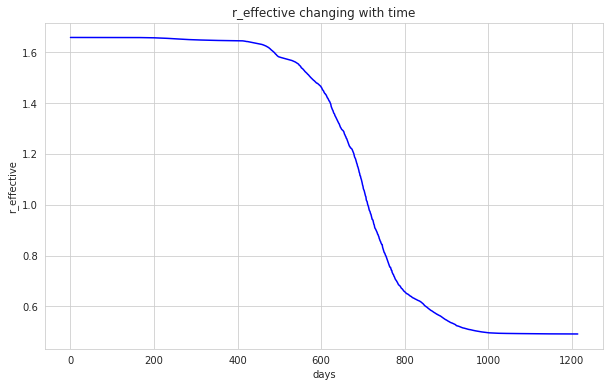

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df["r_eff_actual"], color='b')
plt.xlabel('days')
plt.ylabel('r_effective')
plt.title('r_effective changing with time')
plt.show()

In [23]:
df.index

RangeIndex(start=0, stop=1215, step=1)

In [24]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

print(predicted_gdp)

[101.14017335 101.07290403 101.00788561 100.94508276 100.88446017
 100.82598252 100.76961451 100.71532081 100.66306611 100.61281509
 100.56453245 100.51818286 100.47373101 100.43114159 100.39037928
 100.35140876 100.31419472 100.27870185 100.24489484 100.21273835
 100.18219709 100.15323574 100.12581897 100.09991148 100.07547796
 100.05248308 100.03089153 100.010668    99.99177717  99.97418372
  99.95785235  99.94274774  99.92883457  99.91607752  99.90444129
  99.89389056  99.88439     99.87590432  99.86839819  99.86183629
  99.85618332  99.85140396  99.84746288  99.84432479  99.84195436
  99.84031628  99.83937523  99.8390959   99.83944297  99.84038114
  99.84187507  99.84388946  99.846389    99.84933837  99.85270225
  99.85644533  99.86053229  99.86492782  99.86959661  99.87450334
  99.87961269  99.88488935  99.890298    99.89580334  99.90137003
  99.90696278  99.91254627  99.91808517  99.92354418  99.92888798
  99.93408125  99.93908869  99.94387497  99.94840478  99.9526428
  99.956553

In [25]:
print(max(df['gdp_normalized']), min(df['gdp_normalized']))

df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)

101.242886554856 83.7288107955639


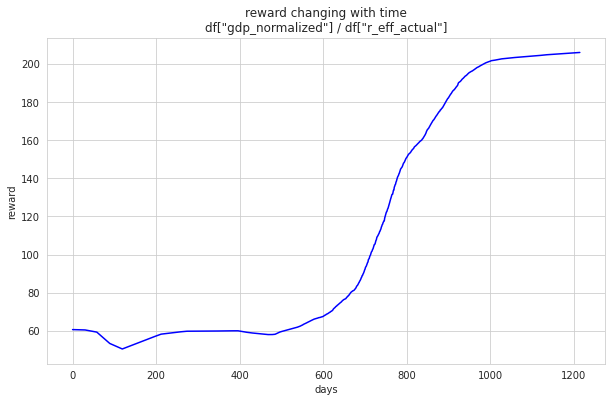

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(df['gdp_normalized'] / df['r_eff_actual'], color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_actual"]')
plt.show()

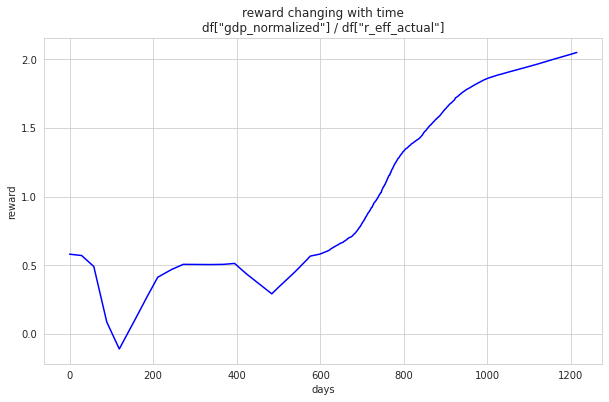

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df['gdp_min_max_normalized'] / df['r_eff_actual'], color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_actual"]')
plt.show()

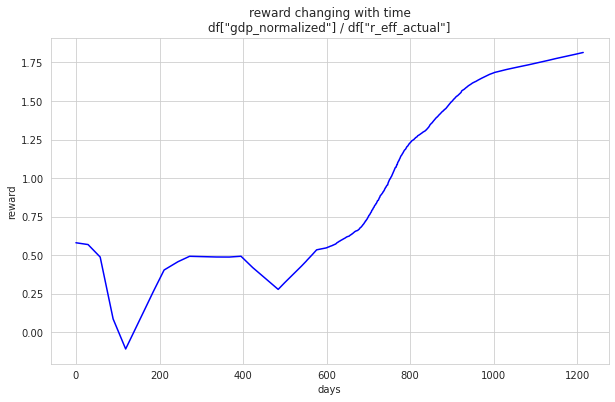

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(df['gdp_min_max_normalized'] / (df['r_eff_actual'] * np.exp(df.index.to_numpy() * 0.0001)), color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_actual"]')
plt.show()

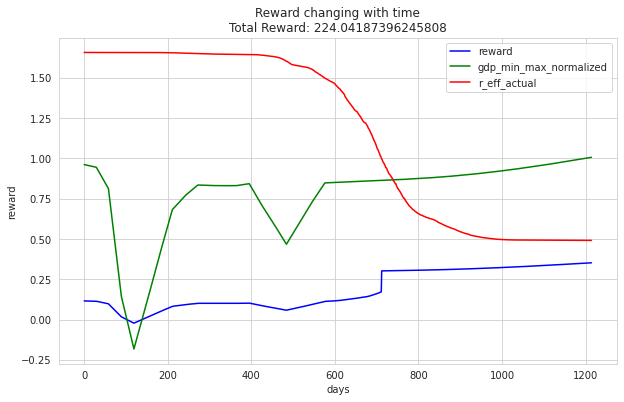

In [29]:
# Define a function that calculates the reward
def calculate_reward(gdp_normalized, r_eff_actual):
    GDP_WEIGHT = 0.35 # change this value and see how it affects the reward
    if r_eff_actual > 1:
        # When r_eff > 1, the reward is more heavily influenced by the reduction in r_eff
        return gdp_normalized / (5 * r_eff_actual)
    else:
        # When r_eff <= 1, the reward is more heavily influenced by the increase in GDP
        return GDP_WEIGHT * gdp_normalized

# Apply the reward function to each day
df['reward'] = df.apply(lambda row: calculate_reward(row['gdp_min_max_normalized'], row['r_eff_actual']), axis=1)

# Plot the reward over time
plt.figure(figsize=(10, 6))
plt.plot(df['reward'], color='b', label='reward')
plt.plot(df['gdp_min_max_normalized'], color='g', label='gdp_min_max_normalized')
plt.plot(df['r_eff_actual'], color='r', label='r_eff_actual')
plt.xlabel('days')
plt.ylabel('reward')
plt.title(f"Reward changing with time\nTotal Reward: {np.sum(df['reward'])}")
plt.legend()
plt.show()

In [30]:
print(df.columns)

Index(['Unnamed: 0', 'date', 'stringency_index', 'total_cases', 'total_deaths',
       'total_vaccinations', 'population', 'people_fully_vaccinated',
       'gdp_normalized', 'N', 'S', 'I', 'R', 'S_modelled', 'I_modelled',
       'R_modelled', 'r_eff_actual', 'gdp_min_max_normalized', 'reward',
       'S_modelled_fakemoves', 'I_modelled_fakemoves', 'R_modelled_fakemoves',
       'r_eff_actual_fakemoves', 'gdp_fakemoves_min_max_normalized',
       'reward_fakemoves'],
      dtype='object')


In [31]:
df.diff()['stringency_index'][1:].describe()

count    1214.000000
mean        0.023641
std         2.203523
min       -14.360000
25%         0.000000
50%         0.000000
75%         0.000000
max        55.560000
Name: stringency_index, dtype: float64

In [32]:
inertia_rewards = [0]
for i in range(1, len(df)):
    diff = df['stringency_index'][i] - df['stringency_index'][i - 1]
    inertia_reward = 10 if diff == 0 else 0
    inertia_rewards.append(inertia_reward)

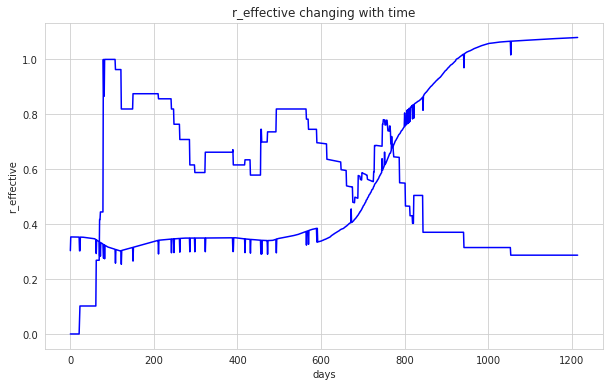

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(df['gdp_normalized'] / df['r_eff_actual'] + inertia_rewards) / 200, color='b')
plt.plot(df['stringency_index'] / 100, color='b')
plt.xlabel('days')
plt.ylabel('r_effective')
plt.title('r_effective changing with time')
plt.show()

In [34]:
r_eff_rewards = []
for i in range(0, len(df)):
    r_eff = df['r_eff_actual'][i]
    r_eff_reward = 20 if r_eff <= 1 else 0
    r_eff_rewards.append(r_eff_reward)

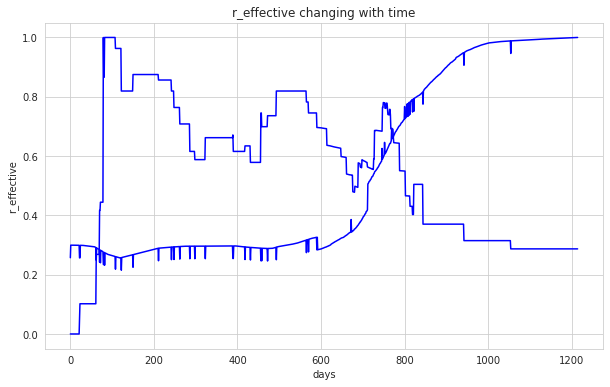

In [35]:
plt.figure(figsize=(10, 6))

total_rewards = np.array(df['gdp_normalized'] / df['r_eff_actual'] + inertia_rewards + r_eff_rewards)
plt.plot(total_rewards / max(total_rewards), color='b')
plt.plot(df['stringency_index'] / 100, color='b')
plt.xlabel('days')
plt.ylabel('r_effective')
plt.title('r_effective changing with time')
plt.show()

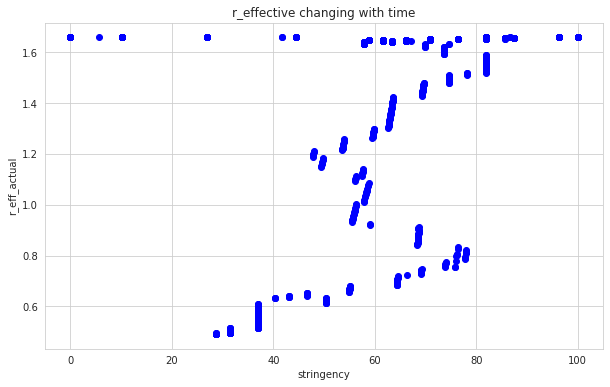

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(df['stringency_index'][:], df['r_eff_actual'][:], color='b')
plt.ylabel('r_eff_actual')
plt.xlabel('stringency')
plt.title('r_effective changing with time')
plt.show()

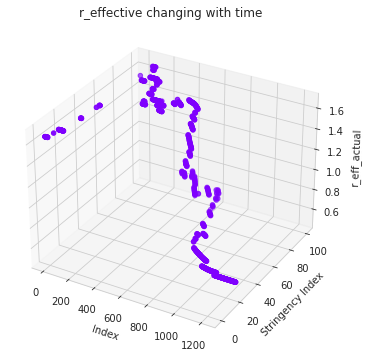

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with df['stringency_index'], df['r_eff_actual'], and df.index
ax.scatter(df.index[:], df['stringency_index'][:], df['r_eff_actual'][:], color='#7F00FF')

ax.set_xlabel('Index')
ax.set_ylabel('Stringency Index')
ax.set_zlabel('r_eff_actual')

plt.title('r_effective changing with time')
plt.show()

In [54]:
# try the reward function with our set of steps and see the results:

stringency_moves = []
for i in range(0, days_difference + 1):
    if i < 1214:
        stringency_move = 0
    else:
        stringency_move = 0
    stringency_moves.append(stringency_move)

stringency_moves = np.array(stringency_moves)
print(stringency_moves)

[0 0 0 ... 0 0 0]


In [52]:
store_S_fakemoves = []
store_I_fakemoves = []
store_R_fakemoves = []

for ith_day in range(0, days_difference + 1):
    t = np.linspace(0, ith_day, ith_day+1)
    stringency_index = stringency_moves[ith_day]
    beta_for_stringency = time_varying_beta(optimal_beta, optimal_stringency_weight, stringency_index)
    predictions = odeint(deriv, y0, t, args=(N, beta_for_stringency, optimal_gamma))
    S, I, R = predictions.T
    store_S_fakemoves.append(S[-1])
    store_I_fakemoves.append(I[-1])
    store_R_fakemoves.append(R[-1])

# TODO: experimenting with stringency_weight here
# betas = time_varying_beta(optimal_beta, optimal_stringency_weight, stringency_moves)

for current_value_of_stringency_weight in np.arange(-1e-3, -1e-4, 1e-6):
    betas = time_varying_beta(optimal_beta, current_value_of_stringency_weight, stringency_moves)
    r0 = betas/optimal_gamma

    df["S_modelled_fakemoves"] = store_S_fakemoves
    df["I_modelled_fakemoves"] = store_I_fakemoves
    df["R_modelled_fakemoves"] = store_R_fakemoves
    df["r_eff_actual_fakemoves"] = r0 * df["S_modelled_fakemoves"]/df["N"]
    first_time_r_eff_1 = next((t for t, r_eff in zip(df.index, df['r_eff_actual_fakemoves']) if r_eff <= 1), None)
    print(current_value_of_stringency_weight, first_time_r_eff_1)
    
    # this is strange because there's a sharp inflection in the model, if the stringency is greater than -0.0002999999999999982
    # r_eff day is zero and below that it jumps to 701 directly. This should probably be a little more 
    # smoother so that the effect of stringency 

-0.001 0
-0.000999 0
-0.0009980000000000002 0
-0.0009970000000000003 0
-0.0009960000000000004 0
-0.0009950000000000004 0
-0.0009940000000000005 0
-0.0009930000000000006 0
-0.0009920000000000007 0
-0.0009910000000000008 0
-0.0009900000000000009 0
-0.000989000000000001 0
-0.000988000000000001 0
-0.0009870000000000011 0
-0.0009860000000000012 0
-0.0009850000000000013 0
-0.0009840000000000014 0
-0.0009830000000000015 0
-0.0009820000000000015 0
-0.0009810000000000016 0
-0.0009800000000000017 0
-0.0009790000000000018 0
-0.0009780000000000019 0
-0.000977000000000002 0
-0.000976000000000002 0
-0.0009750000000000021 0
-0.0009740000000000022 0
-0.0009730000000000023 0
-0.0009720000000000024 0
-0.0009710000000000025 0
-0.0009700000000000025 0
-0.0009690000000000026 0
-0.0009680000000000027 0
-0.0009670000000000028 0
-0.0009660000000000029 0
-0.000965000000000003 0
-0.000964000000000003 0
-0.0009630000000000031 0
-0.0009620000000000032 0
-0.0009610000000000033 0
-0.0009600000000000034 0
-0.0009590

-0.000620000000000032 0
-0.0006190000000000321 0
-0.0006180000000000322 0
-0.0006170000000000322 0
-0.0006160000000000323 0
-0.0006150000000000324 0
-0.0006140000000000325 0
-0.0006130000000000326 0
-0.0006120000000000327 0
-0.0006110000000000327 0
-0.0006100000000000328 0
-0.0006090000000000329 0
-0.000608000000000033 0
-0.0006070000000000331 0
-0.0006060000000000332 0
-0.0006050000000000332 0
-0.0006040000000000333 0
-0.0006030000000000334 0
-0.0006020000000000335 0
-0.0006010000000000336 0
-0.0006000000000000337 0
-0.0005990000000000338 0
-0.0005980000000000338 0
-0.0005970000000000339 0
-0.000596000000000034 0
-0.0005950000000000341 0
-0.0005940000000000342 0
-0.0005930000000000343 0
-0.0005920000000000343 0
-0.0005910000000000344 0
-0.0005900000000000345 0
-0.0005890000000000346 0
-0.0005880000000000347 0
-0.0005870000000000348 0
-0.0005860000000000348 0
-0.0005850000000000349 0
-0.000584000000000035 0
-0.0005830000000000351 0
-0.0005820000000000352 0
-0.0005810000000000353 0
-0.0

-0.00022100000000006555 701
-0.00022000000000006563 701
-0.0002190000000000657 701
-0.0002180000000000658 701
-0.00021700000000006588 701
-0.00021600000000006597 701
-0.00021500000000006605 701
-0.00021400000000006613 701
-0.00021300000000006622 701
-0.0002120000000000663 701
-0.00021100000000006639 701
-0.00021000000000006647 701
-0.00020900000000006655 701
-0.00020800000000006664 701
-0.00020700000000006672 701
-0.0002060000000000668 701
-0.0002050000000000669 701
-0.00020400000000006697 701
-0.00020300000000006706 701
-0.00020200000000006714 701
-0.00020100000000006723 701
-0.0002000000000000673 701
-0.0001990000000000674 701
-0.00019800000000006748 701
-0.00019700000000006756 701
-0.00019600000000006765 701
-0.00019500000000006773 701
-0.00019400000000006782 701
-0.0001930000000000679 701
-0.00019200000000006798 701
-0.00019100000000006807 701
-0.00019000000000006815 701
-0.00018900000000006824 701
-0.00018800000000006832 701
-0.0001870000000000684 701
-0.0001860000000000685 701
-0

In [55]:
betas = time_varying_beta(optimal_beta, optimal_stringency_weight, stringency_moves)
r0 = betas/optimal_gamma

df["S_modelled_fakemoves"] = store_S_fakemoves
df["I_modelled_fakemoves"] = store_I_fakemoves
df["R_modelled_fakemoves"] = store_R_fakemoves
df["r_eff_actual_fakemoves"] = r0 * df["S_modelled_fakemoves"]/df["N"]

-0.00010100000000007564 701


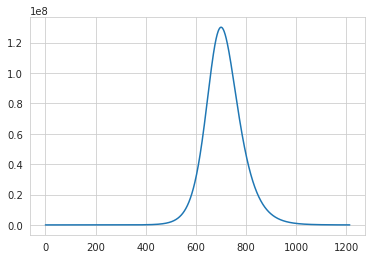

In [56]:
plt.plot(df['I_modelled_fakemoves'])

In [57]:
# try the reward function with our set of steps and see the results:

stringency_moves = []
for i in range(0, days_difference + 1):
    if i < 300:
        stringency_move = 100
    else:
        stringency_move = 0
    stringency_moves.append(stringency_move)

stringency_moves = np.array(stringency_moves)
print(stringency_moves)

[100 100 100 ...   0   0   0]


In [58]:
betas = time_varying_beta(optimal_beta, optimal_stringency_weight, stringency_moves)
r0 = betas/optimal_gamma

df["S_modelled_fakemoves_2"] = store_S_fakemoves
df["I_modelled_fakemoves_2"] = store_I_fakemoves
df["R_modelled_fakemoves_2"] = store_R_fakemoves
df["r_eff_actual_fakemoves_2"] = r0 * df["S_modelled_fakemoves_2"]/df["N"]

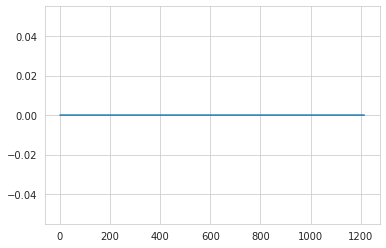

In [62]:
plt.plot(df['I_modelled_fakemoves_2'] - df['I_modelled_fakemoves'])

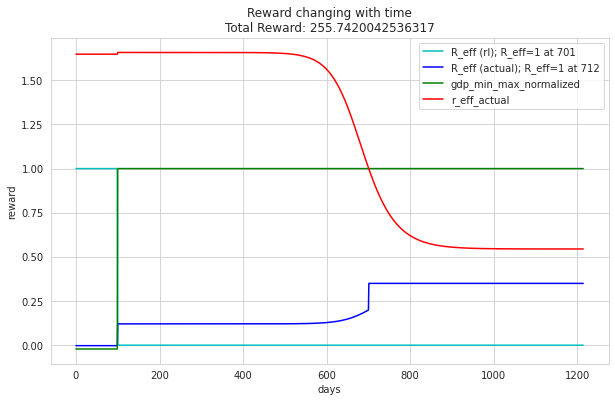

In [51]:
df["gdp_fakemoves_min_max_normalized"] = (fit_line_loaded(stringency_moves) - MIN_GDP) / (MAX_GDP - MIN_GDP)

df['reward_fakemoves'] = df.apply(lambda row: calculate_reward(row['gdp_fakemoves_min_max_normalized'], row['r_eff_actual_fakemoves']), axis=1)

# Plot the reward over time
plt.figure(figsize=(10, 6))
first_time_r_eff_1 = next((t for t, r_eff in zip(df.index, df['r_eff_actual_fakemoves']) if r_eff <= 1), None)
first_time_r_eff_actual_1 = next((t for t, r_eff in zip(df.index, df['r_eff_actual']) if r_eff <= 1), None)
plt.plot(stringency_moves/100, color='c', label='stringency')
plt.plot(df['reward_fakemoves'], color='b', label='reward')
plt.plot(df['gdp_fakemoves_min_max_normalized'], color='g', label='gdp_min_max_normalized')
plt.plot(df['r_eff_actual_fakemoves'], color='r', label='r_eff_actual')
plt.xlabel('days')
plt.ylabel('reward')
plt.title(f"Reward changing with time\nTotal Reward: {np.sum(df['reward_fakemoves'])}")
legend = plt.legend()
legend.get_texts()[0].set_text(f'R_eff (rl); R_eff=1 at {first_time_r_eff_1}')
legend.get_texts()[1].set_text(f'R_eff (actual); R_eff=1 at {first_time_r_eff_actual_1}')
plt.show()